In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import copy
import sys
sys.path.append('../src/')
from util import create_dms_score_matrix

%matplotlib inline

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


# Data

In [2]:
FULL_DMS = pd.read_csv('../data/dms_envfeat_data.csv', index_col=0)
DMS_INFO = pd.read_csv('../data/dms_info.csv', index_col=0)

/Users/fu.j/.conda/envs/wu_etal_2019/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7,8,9,24,25,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Results computed in previous notebook.
bench_perf = pd.read_csv('../result/benchmark_ensemble/performance.csv', index_col=0)
ens_comp_perf = pd.read_csv('../result/train_proportion/performance.csv', index_col=0)

# Overview missing DMS data

## DMS data completeness

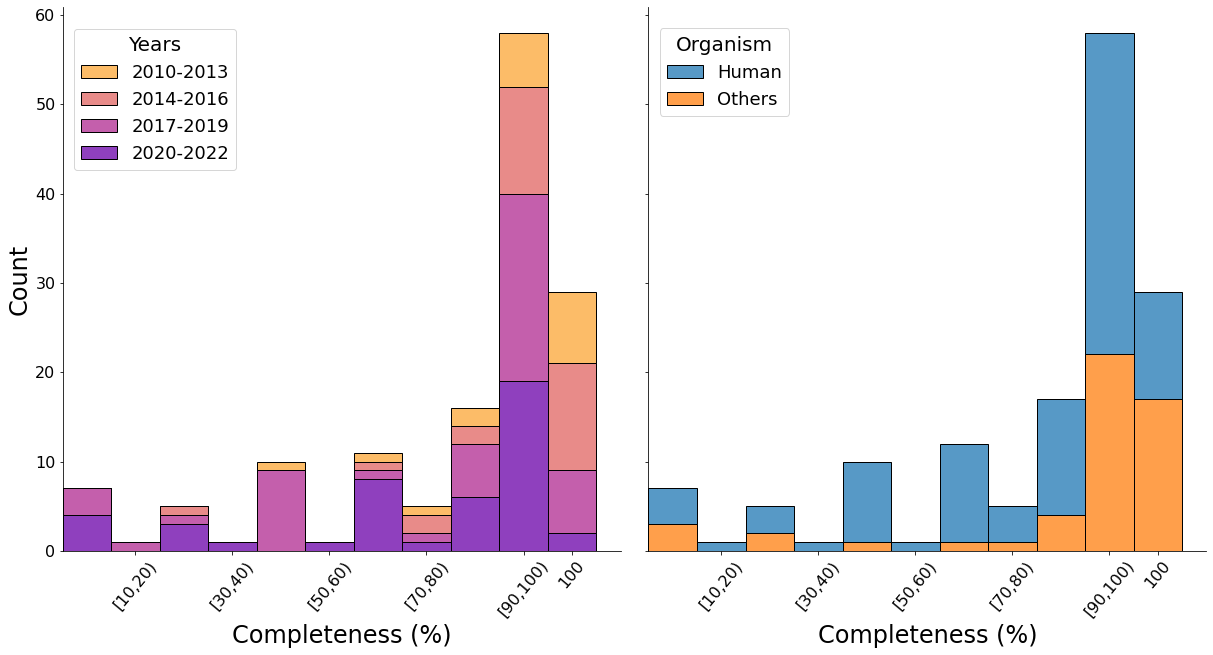

In [5]:
completeness = dict()
for dms, dms_data in FULL_DMS.groupby('dms_id'):
    completeness[dms] = len(dms_data) / (len(dms_data['u_pos'].unique()) * 19)
completeness = pd.Series(completeness).to_frame()
completeness.columns = ['completeness']
completeness.loc[completeness['completeness']==1, 'completeness'] = 1.1

dms_org_map = DMS_INFO.groupby('dms_id')['organism'].first()
dms_year_map = DMS_INFO.groupby('dms_id')['year'].first()
completeness['year'] = completeness.index.map(dms_year_map)
year_round = dict(zip([2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0],
                      ['2010-2013']*4+['2014-2016']*3+['2017-2019']*3+['2020-2022']*3))
completeness['Years'] = completeness['year'].map(year_round)
completeness['Organism'] = (completeness.index.map(dms_org_map) == 'Human')
completeness['Organism'] = completeness['Organism'].map({True: 'Human', False: 'Others'})

fig, axs = plt.subplots(1,2,figsize=(20.5,10), sharey=True)
fig.set_facecolor('w')
plt.subplots_adjust(wspace=0.05)

ax = axs[1]
g = sns.histplot(data=completeness, x='completeness', hue='Organism', multiple="stack", bins=11, binrange=(0,1.1),
            hue_order=['Human', 'Others'], ax=ax)
ax.set_xlim(0,1.15)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks(list(np.arange(0.15,1.05, 0.2))+[1.05])
ax.set_xticklabels([f"[{x-10},{x})" for x in np.arange(20,110, 20)]+[100], fontsize=16, 
                   rotation=50, ha='center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.move_legend(ax, loc=[0.02,0.8], fontsize=18, title_fontsize=20)
#plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_xlabel('Completeness (%)', fontsize=24)

ax = axs[0]
g = sns.histplot(data=completeness, x='completeness', hue='Years', multiple="stack", bins=11, binrange=(0,1.1),
            hue_order=['2010-2013','2014-2016','2017-2019','2020-2022'], palette='plasma_r', ax=ax)
ax.set_xlim(0,1.15)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks(list(np.arange(0.15,1.05, 0.2))+[1.05])
ax.set_xticklabels([f"[{x-10},{x})" for x in np.arange(20,110, 20)]+[100], fontsize=16, 
                   rotation=50, ha='center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.move_legend(ax, loc=[0.02,0.7], fontsize=18, title_fontsize=20)
#plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_xlabel('Completeness (%)', fontsize=24)
ax.set_ylabel('Count', fontsize=24)
plt.show()

## Amino acid completeness

In [6]:
codon_map = dict(zip([x for x in 'FLIMVSPTAYHQNKDECWRG'], [2,6,3,1,4,6,4,4,4,2,2,2,2,2,2,2,2,1,6,4]))
complete_size = []
for dms, dms_data in FULL_DMS.groupby('dms_id'):
    row = dict()
    row['dms_id'] = dms
    row['completeness'] = len(dms_data) / (len(dms_data['u_pos'].unique()) * 19)
    row['size'] = len(dms_data)
    complete_size.append(row)
complete_size = pd.DataFrame(complete_size)
complete_size['organism'] = (complete_size.dms_id.map(dms_org_map) == 'Human')
complete_size['organism'] = complete_size['organism'].map({True: 'Human', False: 'Others'})

../src/util.py:115: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  wt_dms = pd.concat([long_dms, wt_data], ignore_index=True)


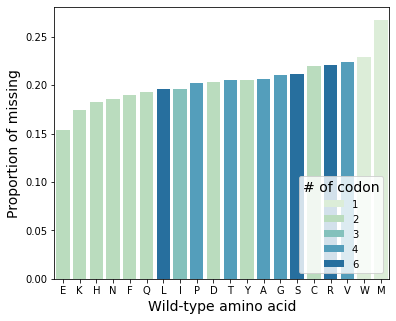

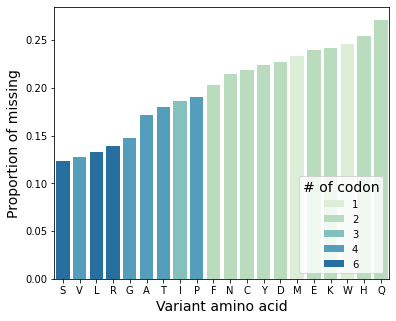

In [7]:
compl_th = 0
pick_dms = complete_size[complete_size['completeness'] > compl_th]['dms_id']
work_smat = create_dms_score_matrix(FULL_DMS.query("dms_id in @pick_dms & u_pos != 1"), wt_score=1)  # <<<<=====

res_mis_count = work_smat.isna().sum(axis=1).reset_index()
res_mis_count = pd.merge(res_mis_count.rename(columns={0: 'mis_count'}), 
                         FULL_DMS[['dms_id', 'position', 'aa1']].drop_duplicates(),
                         on=['dms_id', 'position'], how='left', validate='1:1')
aa1_abund = res_mis_count.groupby('aa1')['position'].count() * 19
aa1_mis_count = res_mis_count.groupby('aa1')['mis_count'].sum()
aa1_mis_count = aa1_mis_count.to_frame()
aa1_mis_count.columns = ['count']
aa1_mis_count['expect'] = aa1_mis_count.index.map(aa1_abund)
aa1_mis_count['ratio'] = aa1_mis_count['count'] / aa1_mis_count['expect']
aa1_mis_count = aa1_mis_count.sort_values('ratio')
aa1_mis_count['aa'] = aa1_mis_count.index
aa1_mis_count['codon_num'] = aa1_mis_count.index.map(codon_map)

aa2_abund = len(work_smat)-res_mis_count.groupby('aa1')['position'].count()
aa2_mis_count = work_smat.isna().sum()
aa2_mis_count = aa2_mis_count.to_frame()
aa2_mis_count.columns = ['count']
aa2_mis_count['expect'] = aa2_mis_count.index.map(aa2_abund)
aa2_mis_count['ratio'] = aa2_mis_count['count'] / aa2_mis_count['expect']
aa2_mis_count = aa2_mis_count.sort_values('ratio')
aa2_mis_count['aa'] = aa2_mis_count.index
aa2_mis_count['codon_num'] = aa2_mis_count.index.map(codon_map)

x_labels = {0: 'Wild-type', 1: 'Variant'}
for i, vis_data in enumerate([aa1_mis_count, aa2_mis_count]):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    #ax2 = ax.twinx()
    fig.set_facecolor('w')
    sns.barplot(data=vis_data, x='aa', y='ratio', hue='codon_num', dodge=False, palette='GnBu', ax=ax)
    #sns.scatterplot(x=np.arange(len(vis_data)), y=vis_data['expect'], ax=ax2, color='orange')
    ax.set_xlabel(f"{x_labels[i]} amino acid", fontsize=14)
    ax.set_ylabel('Proportion of missing', fontsize=14)
    #ax2.set_ylabel('Expected variants', fontsize=14)
    #ax2.set_ylim([0,5e4])
    ax.legend(loc=[.73,.02], title='# of codon', title_fontsize=14)
    plt.show()

## Completeness and codon Hamming distance 

In [8]:
work_smat = create_dms_score_matrix(FULL_DMS, wt_score=1).reset_index()
work_smat = pd.merge(work_smat, FULL_DMS[['dms_id', 'position', 'aa1']].drop_duplicates(), 
                     on=['dms_id', 'position'], validate='1:1', how='left')
long_format = work_smat.melt(id_vars=['dms_id', 'position', 'aa1'], value_vars=[x for x in 'ACDEFGHIKLMNPQRSTVWY'], 
                             value_name='score', var_name='aa2')

total_count = dict()
missing_count = dict()
missing_prop = dict()
for sub_type, df in long_format.groupby(['aa1', 'aa2']):
    total_count[sub_type] = len(df)
    missing_count[sub_type] = df.score.isna().sum()
    missing_prop[sub_type] = df.score.isna().sum() / len(df)

../src/util.py:115: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  wt_dms = pd.concat([long_dms, wt_data], ignore_index=True)


In [9]:
def codon_hamming_distance(codon_1, codon_2):
    """
    examples = [['GCA', 'GCA'],
            ['GCA', 'ACG'],
            ['GCA', 'GCC'],
            ['GCA', 'ATC'],
            ['GCA', 'TTT']]
    results = [0,2,1,3,3]
    """
    distance = 0
    for i in range(3):
        if codon_1[i] != codon_2[i]:
            distance += 1
    return distance

with open('../data/codon.txt', 'r') as file:
    codon = file.read()
codon = [x.split('\t') for x in codon.split('\n')[2:-1]]
codon = pd.DataFrame(codon[1:]).iloc[:, :4]
codon.columns = ['codon', 'aa_tri', 'aa', 'aa_full']
aas = codon.aa.unique()
least_dist = dict()
for aa_i in aas:
    for aa_j in aas:
        for codon_i in codon.query("aa == @aa_i").codon:
            for codon_j in codon.query("aa == @aa_j").codon:
                dist = codon_hamming_distance(codon_i, codon_j)
                if least_dist.get((aa_i, aa_j), 4) > dist:
                    least_dist[(aa_i, aa_j)] = dist

/Users/fu.j/.conda/envs/wu_etal_2019/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


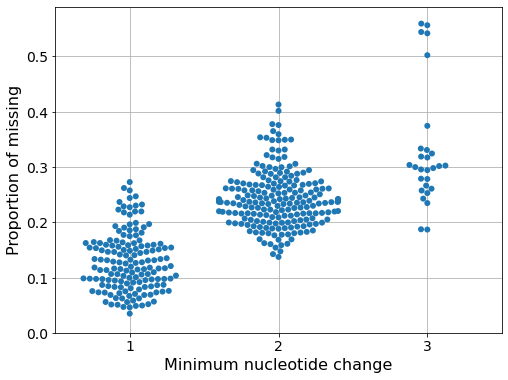

In [10]:
vis_data = pd.Series(missing_prop, name='miss_prop').to_frame()
vis_data['least_codon_distance'] = pd.Series(least_dist)
fig, ax = plt.subplots(1,1,figsize=(8,6))
fig.set_facecolor('w')
sns.swarmplot(data=vis_data.query("least_codon_distance != 0"), x='least_codon_distance', y='miss_prop', 
              color=plt.cm.get_cmap('tab10').colors[0],  s=6)
plt.grid()
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlabel('Minimum nucleotide change', fontsize=16)
plt.ylabel('Proportion of missing', fontsize=16)
plt.ylim(0,0.59)
plt.show()

## Completeness and variant effects

In [36]:
# Create the full score matrix and melt it to find missing variants.
work_smat = create_dms_score_matrix(FULL_DMS, wt_score=1)
work_long = work_smat.reset_index().melt(id_vars=['dms_id','position'], value_name='score')
# Add protein info by residue (necessary, otherwise missing variants will have no info, so can not be featured).
work_long = pd.merge(work_long, FULL_DMS[['uniprot_id', 'dms_id', 'position', 'u_pos', 'aa1']].drop_duplicates(), 
                     on=['dms_id', 'position'], how='left', validate='m:1')
# Remove synonymous ones.
work_long = work_long.query("aa2 != aa1")
predictor_results = pd.read_csv('../data/predictior_results.csv', index_col=0)
work_long = pd.merge(work_long, predictor_results, on=['uniprot_id', 'u_pos', 'aa2'], how='left', validate='m:1')

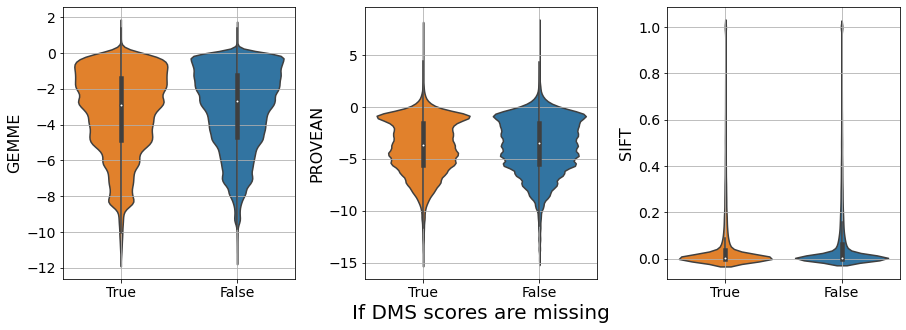

In [37]:
vis_data = work_long.copy()
vis_data['DMS score missing'] = vis_data['score'].isna()
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plt.subplots_adjust(wspace=0.3)
fig.set_facecolor('w')
ylabel_map = dict(zip(['sift_score', 'provean_score', 'gemme_score'], ['SIFT', 'PROVEAN', 'GEMME']))
for i, col in enumerate(['gemme_score', 'provean_score', 'sift_score']):
    g = sns.violinplot(data=vis_data, x='DMS score missing', y=col, hue='DMS score missing', dodge=False, 
                       ax=axs[i], order=[True, False])
    g.legend_.remove()
    axs[i].grid()
    plt.setp(axs[i].get_yticklabels(), fontsize=14)
    plt.setp(axs[i].get_xticklabels(), fontsize=14)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(ylabel_map[col], fontsize=16)
axs[1].set_xlabel('If DMS scores are missing', fontsize=20)
plt.show()

# Develop DMS imputation methods with recommender systems

## DMS scores are highly correlated for certain amino acids

/Users/fu.j/.conda/envs/wu_etal_2019/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


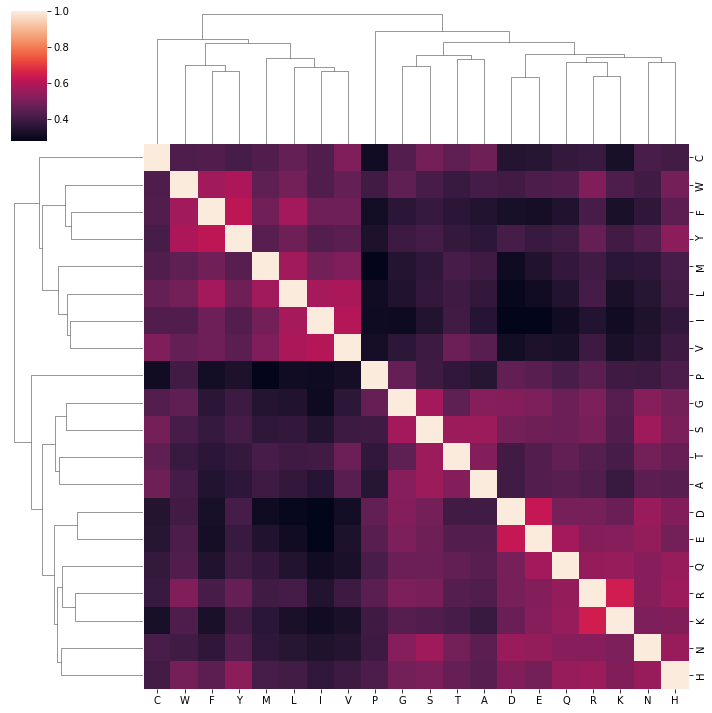

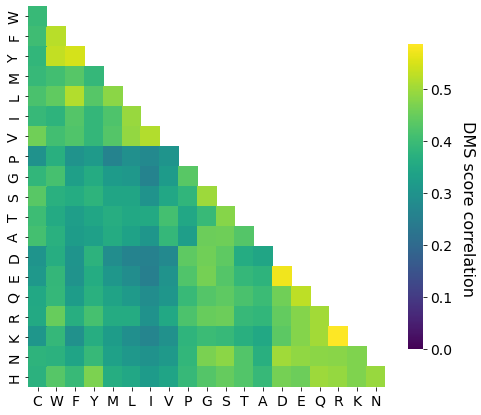

In [45]:
work_data = FULL_DMS.copy()
wt_data = work_data[['dms_id', 'position', 'aa1']].drop_duplicates()
wt_data['aa2'] = wt_data['aa1']
wt_data['score'] = 1
work_data = pd.concat([work_data, wt_data]).pivot_table(index=['dms_id', 'position'], columns='aa2', values='score')

aa_order = [x for x in 'WFYCMLIVPNDEHQRKTAGS']
corr_mat = np.array([[np.nan]*20]*20)
for i, aa_i in enumerate(aa_order[:-1]):
    for j, aa_j in enumerate(aa_order[i+1:]):
        vis_data = work_data[[aa_i, aa_j]].dropna()
        corr_mat[i, i+j+1] = spearmanr(vis_data[aa_i], vis_data[aa_j])[0]
        corr_mat[i+j+1, i] = pearsonr(vis_data[aa_i], vis_data[aa_j])[0]
corr_mat = pd.DataFrame(corr_mat, columns=aa_order, index=aa_order)

# <<<<<<=======
order_mat = corr_mat.copy()
aas = order_mat.index
for i, aai in enumerate(aas):
    order_mat.loc[aai,aai] = 1.
    for j, aaj in enumerate(aas[i+1:]):
        order_mat.loc[aai,aaj] = order_mat.loc[aaj, aai]
g = sns.clustermap(order_mat, metric='euclidean')
aa_order = order_mat.index[g.dendrogram_row.reordered_ind]
# <<<<<<=======

corr_mat = np.array([[np.nan]*20]*20)
for i, aa_i in enumerate(aa_order[:-1]):
    for j, aa_j in enumerate(aa_order[i+1:]):
        vis_data = work_data[[aa_i, aa_j]].dropna()
        corr_mat[i+j+1, i] = spearmanr(vis_data[aa_i], vis_data[aa_j])[0]  # <<<<<=======
corr_mat = pd.DataFrame(corr_mat, columns=aa_order, index=aa_order)

fig, ax = plt.subplots(1,1,figsize=(8,7))
fig.set_facecolor('w')
g = sns.heatmap(corr_mat.iloc[1:,:-1], vmin=0, cmap='viridis', ax=ax, cbar_kws={'shrink': 0.8})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.text(2,0.27,'DMS score correlation', va='center', rotation=270, fontsize=16)
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.show()

# Spearman's correlation between DMS score of each variant amino acid type.

## Coefficient values for AALasso method

In [46]:
coef_sum = pd.read_csv('../result/aalasso/coef_sum.csv', index_col=0)

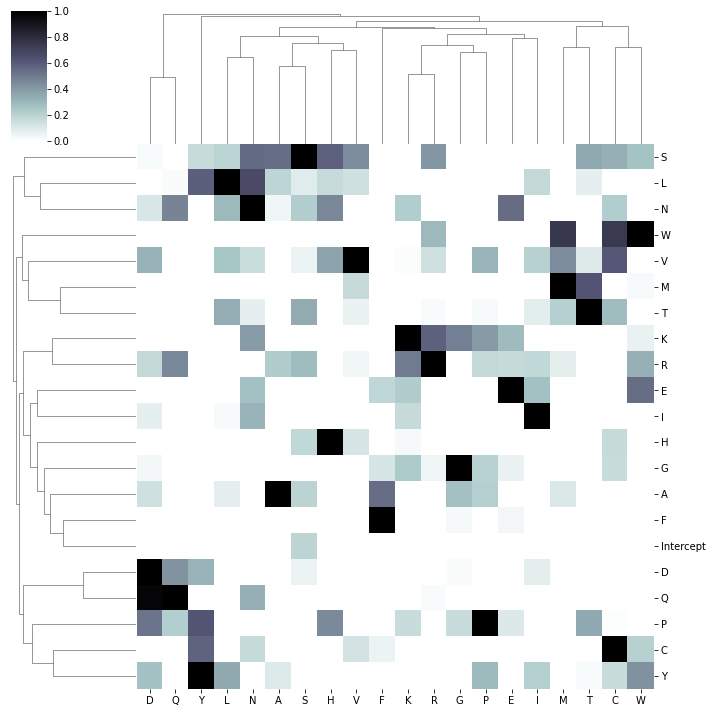

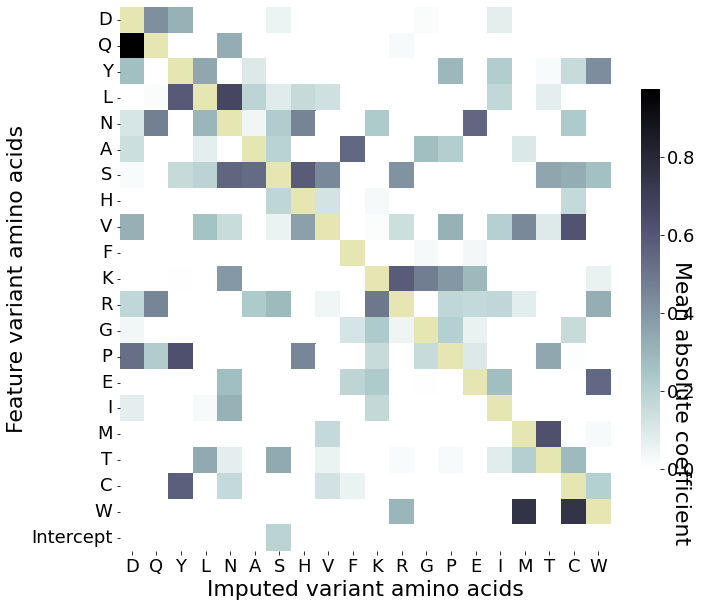

In [48]:
coef = coef_sum.copy()
coef = coef.rename(index={'intercept': 'Intercept'})
cmap = copy.copy(plt.cm.get_cmap('bone_r'))
cmap.set_bad([0.9,0.9,0.7])

# <<<<======
g = sns.clustermap(coef.fillna(1), cmap=cmap, metric='euclidean')
aa_order = list(coef.columns[g.dendrogram_col.reordered_ind])
# <<<<======

fig, ax = plt.subplots(1,1,figsize=(11,10))
g = sns.heatmap(coef.loc[aa_order+['Intercept'], aa_order], cmap=cmap, ax=ax,
                cbar_kws={'shrink': 0.7})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
cbar.ax.text(1.5,0.17,'Mean absolute coefficient', va='center', rotation=270, fontsize=22)
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xlabel('Imputed variant amino acids', fontsize=22)
plt.ylabel('Feature variant amino acids', fontsize=22)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18, rotation=0)
plt.show()

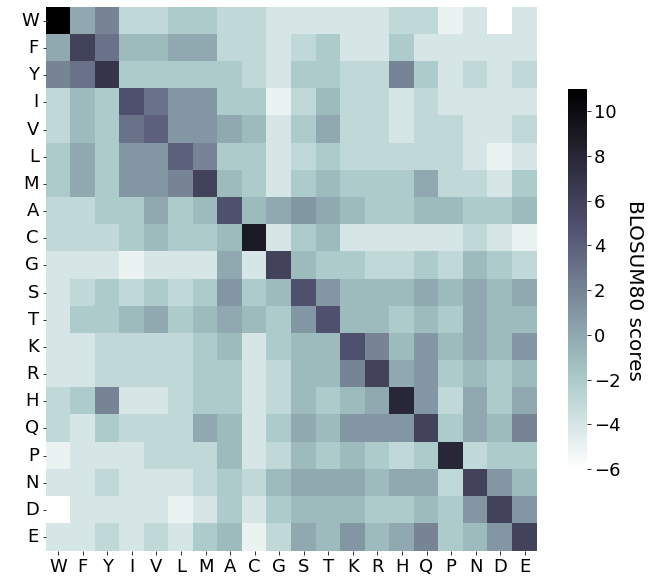

In [51]:
blosum80 = pd.read_csv('../data/blosum80.csv', index_col=0)

cmap = copy.copy(plt.cm.get_cmap('bone_r'))
cmap.set_bad([0.9,0.9,0.7])
aa_order = ['W', 'F', 'Y', 'I', 'V', 'L', 'M', 'A', 'C', 'G', 'S', 'T', 'K', 'R', 'H', 'Q', 'P', 'N', 'D', 'E']
fig, ax = plt.subplots(1,1,figsize=(11,10))
g = sns.heatmap(blosum80.loc[aa_order, aa_order], cmap=cmap, ax=ax, cbar_kws={'shrink': 0.7})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
cbar.ax.text(45,2,'BLOSUM80 scores', va='center', rotation=270, fontsize=20)
ax.figure.axes[-1].yaxis.label.set_size(16)
#plt.xlabel('Imputed variant amino acids', fontsize=22)
#plt.ylabel('Feature variant amino acids', fontsize=22)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18, rotation=0)
plt.show()

# Benchmark DMS imputation methods

## Performance overview

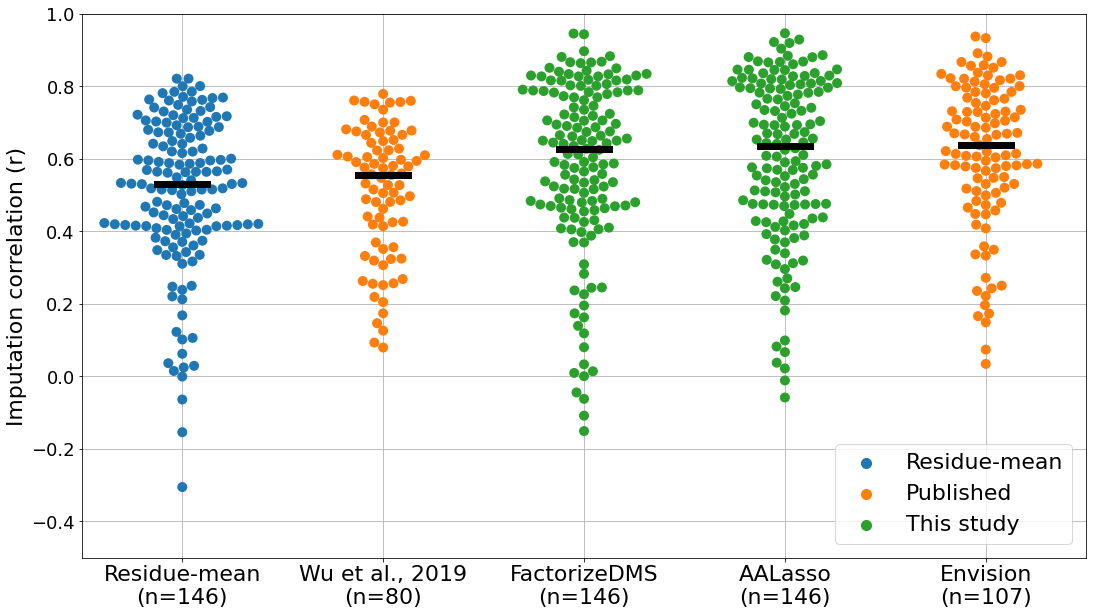

In [34]:
metric = 'pears'

cols = [x+'_'+metric for x in ['row-mean', 'wu2019', 'fdms', 'lasso', 'envision']]
work_data = bench_perf.groupby('dms_id', as_index=False).median()[cols+['dms_id']]
work_data = work_data.melt(id_vars='dms_id', value_vars=cols, var_name='Method', value_name='ρ')
work_data['Type'] = work_data['Method'].map(dict(zip(cols, ['Residue-mean', 'Published', 
                                                            'This study', 'This study',  # <<<<=====
                                                            'Published'])))
name_map = dict(zip(cols, ['Residue-mean', 'Wu et al., 2019', 'FactorizeDMS', 'AALasso', 'Envision']))
xticks = dict()
for met in cols:
    xticks[met] = f"{name_map[met]}\n(n={len(work_data.query('Method==@met').dropna())})"
work_data['Method'] = work_data['Method'].map(xticks)

fig, ax = plt.subplots(1,1,figsize=(18,10))
sns.swarmplot(data=work_data, x='Method', y='ρ', hue='Type', size=10, zorder=2, ax=ax)
sns.boxplot(medianprops={'color': 'k', 'ls': '-', 'lw': 7}, width=.25,
            meanprops={'visible': False}, whiskerprops={'visible': False}, zorder=10,
            x="Method", y='ρ', data=work_data, showfliers=False, showbox=False, showcaps=False,
            ax=ax)
plt.ylim([-0.5,1])
plt.setp(ax.get_xticklabels(), fontsize=22)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.legend(loc=[0.75,0.025], fontsize=22, markerscale=1.3)
plt.xlabel('')
plt.ylabel("Imputation correlation (r)", fontsize=22)
plt.grid()
plt.show()

## AALasso performs better on less-sparse DMS data

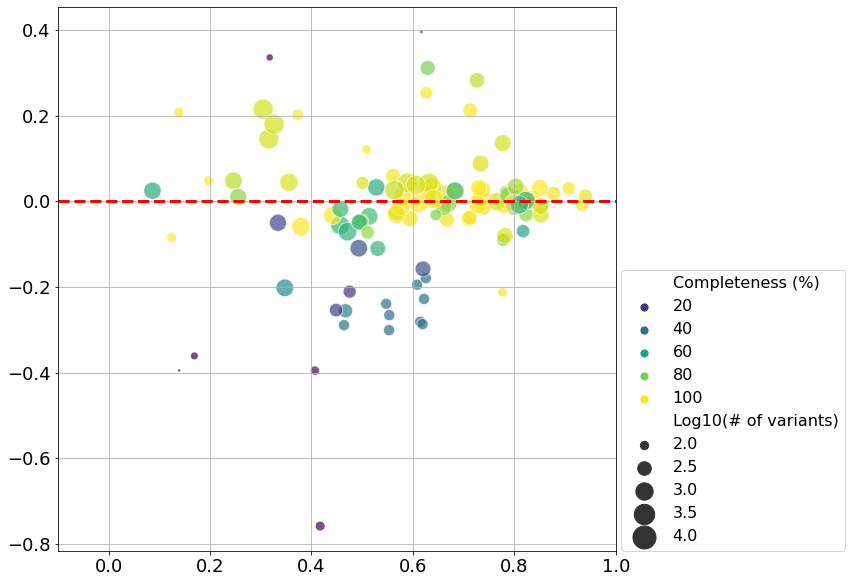

In [35]:
complete_stat = dict()
for dms, data in FULL_DMS.groupby("dms_id"):
    complete_stat[dms] = len(data) / (len(data.u_pos.unique())*19) * 100
size_stat = dict()
for dms, data in FULL_DMS.groupby("dms_id"):
    size_stat[dms] = len(data)
work_data = bench_perf.groupby('dms_id').median()
work_data['Completeness (%)'] = work_data.index.map(complete_stat)
work_data['Log10(# of variants)'] = np.log10(work_data.index.map(size_stat))
work_data['increment'] = work_data['lasso_pears'] - work_data['envision_pears']
work_data['mean_pears'] = (work_data['lasso_pears'] + work_data['envision_pears']) / 2

fig, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.scatterplot(data=work_data, x='mean_pears', y='increment', alpha=0.7,
                hue='Completeness (%)', palette='viridis', ax=ax, size='Log10(# of variants)', sizes=(10,400))
#g.legend(loc=4, fontsize=16, markerscale=1.2, ncol=2)
g.legend(loc=[1.01,0], fontsize=16, markerscale=1.2, ncol=1)
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.xlabel(None)
plt.ylabel(None)
plt.grid()
plt.plot([-0.1,1],[0,0], '--', c='r', lw=3)
plt.xlim([-0.1,1])
plt.show()

## Model performance on different training data proportion

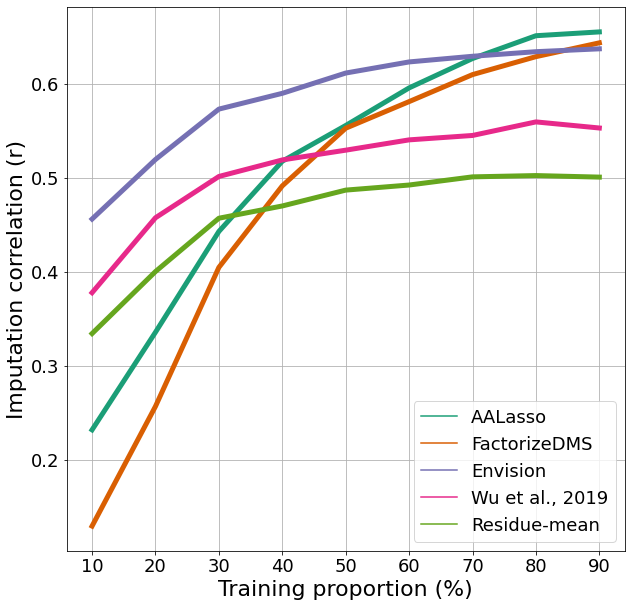

In [37]:
completeness_perf = ens_comp_perf.melt(id_vars=['dms_id', 'repeat', 'completeness'], value_name='Test Pearson\'s ρ', var_name='method',
                                       value_vars=['row-mean_pred', 'fdms_pred', 'lasso_pred', 'envision_pred', 'wu2019_pred', 'pred_score'])
completeness_perf['train_ratio_vs_full'] = completeness_perf['completeness'].astype(float).round(2)
completeness_perf.loc[completeness_perf['train_ratio_vs_full']>0.8, 'train_ratio_vs_full'] = 0.9
completeness_perf['train_ratio_vs_full'] = completeness_perf['train_ratio_vs_full'] * 100
methods = ['row-mean_pred', 'fdms_pred', 'lasso_pred', 'envision_pred', 'wu2019_pred', 'pred_score']
completeness_perf['Type'] = completeness_perf['method'].map(dict(zip(methods, ['Residue-mean', 'This study', 'This study',  # <<<<=====
                                                                                 'Published', 'Published', 'Ensemble'])))  # <<<<<<=====
completeness_perf['Method'] = completeness_perf['method'].map(dict(zip(methods, ['Residue-mean', 'FactorizeDMS',
                                                                                 'AALasso', 'Envision', 'Wu et al., 2019', 'Ensemble'])))

fig, ax = plt.subplots(1,1,figsize=(10,10))
data = completeness_perf.copy()
data = data.groupby(['train_ratio_vs_full', 'repeat', 'Method', 'Type'], as_index=False).median()
sns.lineplot(data=data, x='train_ratio_vs_full', y="Test Pearson's ρ", hue='Method', palette='Dark2', ci=None, linewidth=5,
             # <<<<<<=====
             hue_order=['AALasso', 'FactorizeDMS', 'Envision', 'Wu et al., 2019', 'Residue-mean'])
plt.grid()
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.legend(loc=4, fontsize=18)  # <<<<<=====
plt.ylabel("Imputation correlation (r)", fontsize=22)
plt.xlabel("Training proportion (%)", fontsize=22)
plt.show()

# Build Ensemble method for DMS imputation

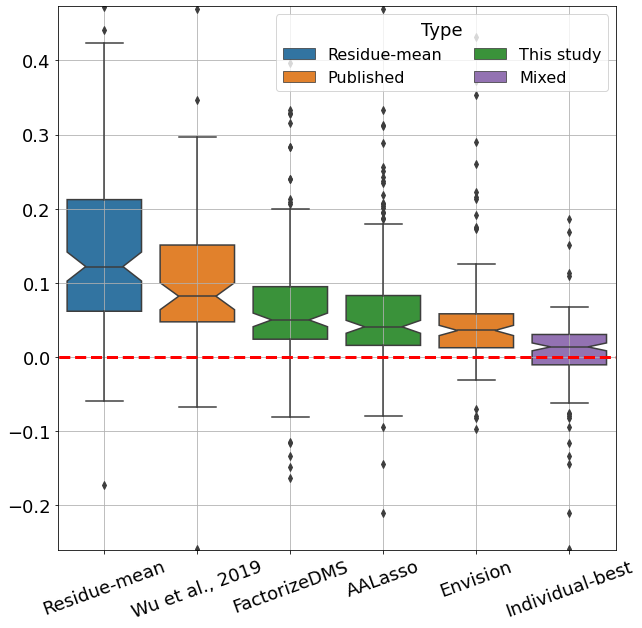

In [38]:
metric = 'pears'

work_data = bench_perf.groupby('dms_id', as_index=False).median()
indiv_best = work_data[[x+'_'+metric for x in ['row-mean', 'wu2019', 'fdms', 'lasso', 'envision']]]
work_data['indiv-best_pears'] = indiv_best.max(axis=1)
vis_data = []
for i, met in enumerate(['lasso', 'fdms', 'row-mean', 'envision', 'wu2019', 'indiv-best']):
    i_col = f"{met}_{metric}"
    j_col = f"ensemble_{metric}"
    foo = work_data[[i_col, j_col, 'dms_id']].copy()
    foo = foo.dropna()  # missing feature
    foo["diff"] = foo[j_col] - foo[i_col]
    foo['method'] = met
    foo['Type'] = dict(zip(['lasso', 'fdms', 'row-mean', 'envision', 'wu2019', 'indiv-best'], 
                           ['This study', 'This study', 'Residue-mean', 'Published', 'Published', 'Mixed']))[met] # <<<<=====
    vis_data.append(foo[['diff', 'method', 'dms_id', 'Type']])
vis_data = pd.concat(vis_data, ignore_index=True)
vis_data['Method'] = vis_data['method'].map(dict(zip(['row-mean', 'wu2019', 'fdms', 'lasso', 'envision', 'indiv-best'], 
                                                     ['Residue-mean', 'Wu et al., 2019', 'FactorizeDMS', 'AALasso', 'Envision', 'Individual-best'])))
    
cmap = []
for i in [0,1,2,4]:
    cmap.append(plt.cm.get_cmap('tab10', 10)(i))
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.boxplot(data=vis_data, x='Method', y='diff', notch=True, dodge=False, hue='Type',
            order=['Residue-mean', 'Wu et al., 2019', 'FactorizeDMS', 'AALasso', 'Envision', 'Individual-best'],
            hue_order=['Residue-mean', 'Published', 'This study', 'Mixed'], palette=cmap)
plt.grid()
plt.setp(ax.get_xticklabels(), fontsize=18, rotation=20)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.plot([-1,6],[0,0], '--', c='r', lw=3)
plt.ylabel('')
plt.xlabel('')
plt.legend(loc=1, fontsize=16, title='Type', title_fontsize=18, ncol=2) # <<<<=====
plt.xlim([-0.5, 5.5])
plt.ylim([-0.26, 0.473]) # <<<<=====
plt.show()

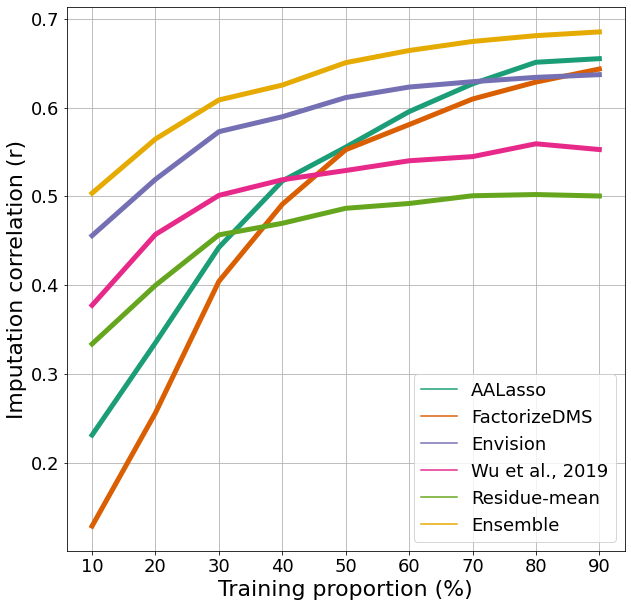

In [39]:
completeness_perf = ens_comp_perf.melt(id_vars=['dms_id', 'repeat', 'completeness'], value_name='Test Pearson\'s ρ', var_name='method',
                                       value_vars=['row-mean_pred', 'fdms_pred', 'lasso_pred', 'envision_pred', 'wu2019_pred', 'pred_score'])
completeness_perf['train_ratio_vs_full'] = completeness_perf['completeness'].astype(float).round(2)
completeness_perf.loc[completeness_perf['train_ratio_vs_full']>0.8, 'train_ratio_vs_full'] = 0.9
completeness_perf['train_ratio_vs_full'] = completeness_perf['train_ratio_vs_full'] * 100
methods = ['row-mean_pred', 'fdms_pred', 'lasso_pred', 'envision_pred', 'wu2019_pred', 'pred_score']
completeness_perf['Type'] = completeness_perf['method'].map(dict(zip(methods, ['Residue-mean', 'This study', 'This study',  # <<<<=====
                                                                                 'Published', 'Published', 'Ensemble'])))  # <<<<<<=====
completeness_perf['Method'] = completeness_perf['method'].map(dict(zip(methods, ['Residue-mean', 'FactorizeDMS',
                                                                                 'AALasso', 'Envision', 'Wu et al., 2019', 'Ensemble'])))

fig, ax = plt.subplots(1,1,figsize=(10,10))
data = completeness_perf.copy()
data = data.groupby(['train_ratio_vs_full', 'repeat', 'Method', 'Type'], as_index=False).median()
sns.lineplot(data=data, x='train_ratio_vs_full', y="Test Pearson's ρ", hue='Method', palette='Dark2', ci=None, linewidth=5,
             # <<<<<<=====
             hue_order=['AALasso', 'FactorizeDMS', 'Envision', 'Wu et al., 2019', 'Residue-mean', 'Ensemble'])
plt.grid()
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.legend(loc=4, fontsize=18)  # <<<<<=====
plt.ylabel("Imputation correlation (r)", fontsize=22)
plt.xlabel("Training proportion (%)", fontsize=22)
plt.show()